In [24]:
import numpy as np
from matplotlib.pyplot import figure, Rectangle
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setting main directories

In [27]:
pathdict = {}

# Root project directory where the shampoo.py and this notebook are located.
pathdict["project"] = str(Path("..").resolve())

# Change this variable to the folder where your ProDiMo model output is located.
pathdict["disk"] = pathdict["project"] + "/input/prodimo/vfrag1"

# Location and name of the input file.
pathdict["input"] = pathdict["project"] + "/input/parameters/"

# Folder where the model data of monomer simulations are saved and where simulations are loaded from.
pathdict["simulation"] = pathdict["project"] + "/output/monomers/"

# Folder where the figure files are saved.
pathdict["figures"] = pathdict["project"] + "/output/figures/"



# Loading the background model

In [40]:
from src.model.entities.disk import Disk
from src.model import Model

disk = pickle.load(open(pathdict["project"] + "/input/disks/vfrag1_disk.pkl", "rb"))
# disk = Disk(species=["H2O", "CO", "CO2", "CH4", "CH3OH", "NH3", "H2S", "SO2", "OCS"], folder=pathdict["disk"], modelName="ProDiMo.out",
#                     t_index="{:04d}".format(5))

# The plotting script

In [46]:
plt.rcParams['legend.title_fontsize'] = '14'
def calculateShades(mod):

    
    expArr = mod.monomer.sec_sol["exposed"] 
    
    if expArr[0]==1:
        startPos = [0]
    else:
        startPos = []
    stopPos = []
    
    for t in range(1,len(expArr)):
        if ((mod.monomer.sec_sol["exposed"])[t]==1)and ((mod.monomer.sec_sol["exposed"])[t-1]==0):
            startPos.append(mod.monomer.t_sol[t])
            
        elif ((mod.monomer.sec_sol["exposed"])[t]==0)and ((mod.monomer.sec_sol["exposed"])[t-1]==1):
            stopPos.append(mod.monomer.t_sol[t])
    
    if (mod.monomer.sec_sol["exposed"])[-1]==1:
        stopPos.append(mod.monomer.t_sol[-1])

    xwidths = np.array(stopPos)-np.array(startPos)
    
    return startPos, stopPos, xwidths
        
def addShapes(frame, startPos, stopPos, xwidths):
    
    for n in range(len(xwidths)):
        frame.add_patch(Rectangle((startPos[n], -5e5), xwidths[n], 1e10, facecolor=(0,.6,0), alpha=.25))
        

def testModel(disk, pathdict, tMin, tMax, generate=False, name="DemoModel", inputName=None):
    """
    Auxiliary function meant for testing the model.
    
    entities: Instance of Disk which serves as the background model.
    tMin: lower xlim in kyr
    tMax: upper xlim in kyr
    generate: (Re)Do the integration (True) or look for file of name "Model" (False)
    name: Model save file name.
    """
    
    #---------------------------------------------------------------------------------------
    
    if inputName==None:
        inputName = name
    
    if generate:
        config = {
            "parameter_folder": pathdict["input"] + inputName,
            "disk_folder": pathdict["disk"],
            "verbose": 0
        }
        print(config)
        mod = Model(disk=disk, user_config=config)
        mod.integrateMonomer()
        pickle.dump(mod, open(pathdict["simulation"]+name+".pkl", "wb"))
    else:
        try:
            mod = pickle.load(open(pathdict["simulation"]+name+".pkl", "rb"))
            print("Loaded model with seed: ", mod.seedStart)
        except:
            mod = None
            print("Did not find file: ",pathdict["simulation"]+name+".pkl")
       
 
    frameTotList = []
    
    if mod.trackice:
        startPos, stopPos, xwidths = calculateShades(mod)
    #---------------------------------------------------------------------------------------
    
    if mod.migration:
        figDyn = figure(figsize=(12,7))   # Figure relevant for the dynamics. Tracks the particle position.
        frameDynList = [None]*4
        
        for f in range(4):
            frameDynList[f] = figDyn.add_subplot(2,2,f+1)
            if mod.trackice:
                addShapes(frameDynList[f], startPos, stopPos, xwidths)
        

        frameDynList[0].plot(mod.monomer.t_sol, mod.monomer.z_sol/mod.monomer.r_sol, zorder=1, 
                             linewidth=2)
        frameDynList[1].plot(mod.monomer.t_sol, mod.monomer.r_sol, zorder=1, 
                             linewidth=2)
        frameDynList[2].plot(mod.monomer.t_sol, mod.monomer.sec_sol["Td"], zorder=1, 
                             linewidth=2)
        frameDynList[3].semilogy(mod.monomer.t_sol, mod.monomer.sec_sol["chiRT"], zorder=1, 
                                 linewidth=2)

        frameDynList[0].set_ylabel("z/r", fontsize=16)
        frameDynList[1].set_ylabel("r (AU)", fontsize=16)
        frameDynList[2].set_ylabel("Monomer temperature (K)", fontsize=16)
        frameDynList[3].set_ylabel(r"UV radiation field ($F_{Draine}$)", fontsize=16)
            
        maxZ = 1.2*np.max(mod.monomer.z_sol/mod.monomer.r_sol)
            
        minR = np.max([0,0.8*np.min(mod.monomer.r_sol)])
        maxR = 1.2*np.max(mod.monomer.r_sol)
          
        minT = 0.8*np.min(mod.monomer.sec_sol["Td"])
        maxT = np.min([250,1.2*np.max(mod.monomer.sec_sol["Td"])])
        
        minX = 1e-10#0.1*np.min(stackX)
        maxX = max([10*np.max(mod.monomer.sec_sol["chiRT"]), 10])
        
        frameDynList[0].plot([tMin,tMax],[0,0], linewidth=3, color=(0,0,0), linestyle="--")
        frameDynList[3].plot([tMin,tMax],[1,1], linewidth=3, color=(0,0,0), linestyle="--")
        
        
        
        frameDynList[0].set_ylim(-maxZ,maxZ)
        frameDynList[1].set_ylim(minR,maxR)
        frameDynList[2].set_ylim(0,maxT)
        frameDynList[3].set_ylim(minX, maxX)
        
        figDyn.tight_layout(pad=3)
        frameTotList.append(frameDynList)
    
    #---------------------------------------------------------------------------------------
    

    #---------------------------------------------------------------------------------------
    
    if mod.collisions:
        figCoa = figure(figsize=(12,4))     # Figure which tracks home aggregate size and latest collisional interaction.
        
        frameCoa = figCoa.add_subplot(1,1,1)
        #frameRel = figCoa.add_subplot(2,1,2)
        #frameCoaList = [frameCoa, frameRel]
        frameCoaList = [frameCoa]
        
        # Panel 1
        #tAuxsol = np.copy(mod.monomer.t_sol)
        #sAuxsol = np.copy(mod.monomer.sAgg_sol)
        #L = len(mod.monomer.t_sol)
        #l = 1
        
        
        #inds = np.where((sAuxsol[0:-1]-sAuxsol[1::])!=0, np.indices, 0)
        #print(inds)
        
        frameCoaList[0].semilogy(mod.monomer.t_sol, mod.monomer.sAgg_sol, zorder=-1, color=(.5,.5,.5), linewidth=2)
        interactionList = ["Nothing", "Coagulation", "Fragmentation", "Erosion", "Ejection", "Impact"]
            
        for t in range(1,6):
            cond = np.argwhere(mod.monomer.sec_sol["interaction"]==t)
            tArr = mod.monomer.t_sol[cond]
            data = mod.monomer.sAgg_sol[cond]
            frameCoaList[0].scatter(tArr, data, label=interactionList[t])
    
        frameCoaList[0].set_ylabel("Home aggregate size", fontsize=16)
        frameCoaList[0].legend(title="Collision event", loc="lower center", ncol=5, fontsize=12, bbox_to_anchor=(0., -.45, 1., 0.5))

        frameTotList.append(frameCoaList)
   
    #---------------------------------------------------------------------------------------

    if mod.trackice:
        figIce1 = figure(figsize=(18,4))
        figIce2 = figure(figsize=(12,4))
        # Figure which contains 1. monomer depth, 2. total ice budget, 3. ice abundance, 
                                            # 4. element abundance, 5. element ratios
        
        frameIceList = [None]*5
        
        for f in range(5):
            if f<3:
                #if f==0: ##################### Temporary change for EPSC abstract
                frameIceList[f] = figIce1.add_subplot(1,3,f+1) 
#                 elif f==1:
#                     frameIceList[f] = figIce1.add_subplot(1,3,1)
#                 else:
#                     frameIceList[f] = figIce1.add_subplot(1,3,f+1)
            else:
                frameIceList[f] = figIce2.add_subplot(1,2,f-2)
            

            addShapes(frameIceList[f], startPos, stopPos, xwidths)
         
            
        
        # Panel 1: Monomer depth in home aggregate.
        colorExposed = (0,.6,0)
        colorIsolate = (1,0,0)
        exposed = np.ma.masked_where(mod.monomer.sec_sol["exposed"]==0, mod.monomer.zMon_sol)
        isolate = np.ma.masked_where(mod.monomer.sec_sol["exposed"]==1, mod.monomer.zMon_sol)
            
        frameIceList[0].semilogy(mod.monomer.t_sol, exposed, zorder=1, linewidth=2, color=colorExposed)
        frameIceList[0].semilogy(mod.monomer.t_sol, isolate, zorder=1, linewidth=2, color=colorIsolate)
            
        for t in range((len(mod.monomer.t_sol)-1)):
               
            if (mod.monomer.sec_sol["exposed"][t+1]!=mod.monomer.sec_sol["exposed"][t]):
                xDat = [mod.monomer.t_sol[t], mod.monomer.t_sol[t+1]]
                yDat = [mod.monomer.zMon_sol[t], mod.monomer.zMon_sol[t+1]]
                    
                if mod.monomer.sec_sol["exposed"][t]==0:
                    frameIceList[0].semilogy(xDat, yDat, zorder=1, linewidth=2, color=colorIsolate)
                else:
                    frameIceList[0].semilogy(xDat, yDat, zorder=1, linewidth=2, color=colorExposed)
            
            
        
        #frameIceList[0].semilogy(mod.monomer.t_sol, mod.monomer.zMon_sol, zorder=1, linewidth=2)
        frameIceList[0].plot([mod.monomer.t_sol[0], mod.monomer.t_sol[-1]], [mod.monomer.prop["zCrit"],mod.monomer.prop["zCrit"]], color=(0,0,0), linewidth=2, linestyle="--")
        frameIceList[0].set_ylim(1e-8, 1e-2)
        frameIceList[0].annotate(r"$z_m=z_{crit}$", (82, mod.monomer.prop["zCrit"]*0.7), fontsize=12)
        
        
        
        # Panel 2: Monomer total ice mass.

        frameIceList[1].plot(mod.monomer.t_sol, mod.monomer.iceTot_sol/mod.monomer.prop["mMon"], zorder=1, linewidth=2)
        frameIceList[1].set_ylim(0,1.2*np.max(mod.monomer.iceTot_sol/mod.monomer.prop["mMon"]))

        for item in disk.iceList:
            relVal = (mod.monomer.ice_sol[item])/mod.monomer.iceTot_sol
            #print(relVal)
            relVal[mod.monomer.iceTot_sol<1e-99] = 0
            #if np.max(relVal)>0.05:
            frameIceList[2].semilogy(mod.monomer.t_sol, relVal, label=item, linewidth=2)
            #else:
            #    frameIceList[2].semilogy(mod.monomer.t_sol, relVal, linewidth=2, color=(.5,.5,.5))
            frameIceList[2].set_ylim(1e-14,2e0)
        # Panel 4: Abundance of elements in the ice mantle.
        E = 5
        colorList = [(0,0,1),(0,0,0),(1,0,1),(1,0,0),(1,.8,.1)]
        elementList = ["H", "C", "N", "O", "S"]
        for e in range(E):
            relVal = mod.monomer.ele_sol[:,e]/mod.monomer.iceTot_sol
            relVal[mod.monomer.iceTot_sol<1e-99] = 0
            frameIceList[3].semilogy(mod.monomer.t_sol, relVal, color=colorList[e], linewidth=2, label=elementList[e])
            
        frameIceList[3].set_ylim(1e-9, 1e0)
        # Panel 5: Element ratios.
        for item in mod.monomer.sec_sol.keys():
            if item[0:3]=="rat":
                frameIceList[4].semilogy(mod.monomer.t_sol, mod.monomer.sec_sol[item], linewidth=2, label=item[-3::])
        frameIceList[4].set_ylim(1e-9, 1e2)
    

    
        frameIceList[0].set_ylabel(r"Monomer depth $z_m$ (m)", fontsize=16)
        frameIceList[1].set_ylabel(r"Total ice mass ($m_{ice}/m_m$)", fontsize=16)
        frameIceList[2].set_ylabel(r"Mass fraction", fontsize=16)
        frameIceList[2].legend(title="Molecule", loc="lower left", ncol=3, fontsize=14)
        frameIceList[3].set_ylabel(r"Mass fraction", fontsize=16)
        frameIceList[3].legend(title="Element", fontsize=14, ncol=3)
        frameIceList[4].set_ylabel(r"Element ratio", fontsize=16)
        frameIceList[4].legend(title="Ratio", fontsize=14, ncol=3)
        
        frameIceList[0].invert_yaxis()
    
        figIce1.tight_layout(pad=2)
        figIce2.tight_layout(pad=2)
        frameTotList.append(frameIceList)
    #---------------------------------------------------------------------------------------
    
    figNum = figure(figsize=(6,4))               # Figure which tracks the timestep size.
    frameNum = figNum.add_subplot(1,1,1)
    frameNumList = [frameNum]
        
    frameNumList[0].semilogy(mod.monomer.t_sol, mod.monomer.sec_sol["delta_t"]/mod.sTOyr, zorder=1, linewidth=2)
    
    frameNumList[0].set_ylabel("Timestep size (yr)", fontsize=18)
    
    figNum.tight_layout(pad=2)
    frameTotList.append(frameNumList)
    
    for frames in frameTotList:
        for f in frames:
            f.set_xlim(tMin, tMax)
            f.set_xlabel("Time (kyr)", fontsize=18)
            f.grid()
            f.tick_params(labelsize=14)
        
        
    for fmt in ["pdf"]:
        
        if mod.migration:
            figDyn.savefig(pathdict["figures"]+name+"Dynamics."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
        
        if mod.trackice:
            figIce1.tight_layout(pad=1)
            figIce1.savefig(pathdict["figures"]+name+"IceEvolution1."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
            figIce2.savefig(pathdict["figures"]+name+"IceEvolution2."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
        
        if mod.collisions:
            figCoa.savefig(pathdict["figures"]+name+"Collisions."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
            
        figNum.savefig(pathdict["figures"]+name+"Numerics."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)

    print("Done!")

# Example output

{'parameter_folder': 'C:\\Users\\moost\\Documents\\Code\\shampoo/input/parameters/DemoModel', 'disk_folder': 'C:\\Users\\moost\\Documents\\Code\\shampoo/input/prodimo/vfrag1', 'verbose': 0}
{'parameter_folder': 'C:\\Users\\moost\\Documents\\Code\\shampoo/input/parameters/DemoModel', 'disk_folder': 'C:\\Users\\moost\\Documents\\Code\\shampoo/input/prodimo/vfrag1', 'verbose': 0, 'species': ['H2O', 'CO', 'CO2', 'CH4', 'NH3', 'H2S'], 'migration': None, 'diffusion': None, 'collisions': None, 'trackice': None, 'debug': False, 'save_csv': [False, None], 'phi': None, 'breakIce': False, 'legacyIce': False, 'colEq': False, 'storage_style': 0, 'readsorption': False, 'supverbose': False, 'qTest': False, 'qTestAds': False, 'qTestMig': False, 'activeML': True}
 ------------------------------------------------------------------------ 
|                                                                        |
|                           Welcome to SHAMPOO                           |
|                 

C:\Users\moost\Documents\Code\shampoo\src\model\init\initializers\parameters.py:49: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  dataName = np.loadtxt(filepath + "/AdsorptionEnergies.in", dtype="str", comments="#", usecols=(0), encoding=None)


Monomer placed in aggregate:
sAgg:          5.00e-08 m
zMon:          0.00e+00 m
State:          exposed
Initialized ice budget.
--------------------------------------------------
 
Finished monomer initialization, commencing time evolution...
 
--------------------------------------------------
 
Integration progress: 0.00 % complete, estimated time left: 0.00 s, current step size: 1.0e+00 yr        
Integration progress: 1.13 % complete, estimated time left: 498.74 s, current step size: 1.1e+03 yr        
Integration progress: 2.25 % complete, estimated time left: 247.61 s, current step size: 1.1e+03 yr        
Integration progress: 3.38 % complete, estimated time left: 163.08 s, current step size: 1.1e+03 yr        
Integration progress: 4.50 % complete, estimated time left: 121.06 s, current step size: 1.1e+03 yr        
Integration progress: 5.60 % complete, estimated time left: 96.34 s, current step size: 1.1e+03 yr        
Integration progress: 6.73 % complete, estimated time le

C:\Users\moost\Documents\Code\shampoo\src\model\integrator\timescales.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  tauMz = Hp / vz


Integration progress: 13.76 % complete, estimated time left: 37.13 s, current step size: 4.9e+01 yr        
Integration progress: 13.81 % complete, estimated time left: 37.07 s, current step size: 5.0e+01 yr        
Integration progress: 13.86 % complete, estimated time left: 36.91 s, current step size: 5.2e+01 yr        
Integration progress: 13.91 % complete, estimated time left: 36.75 s, current step size: 5.1e+01 yr        
Integration progress: 13.96 % complete, estimated time left: 36.69 s, current step size: 5.2e+01 yr        
Integration progress: 14.00 % complete, estimated time left: 36.57 s, current step size: 3.9e+01 yr        
Integration progress: 14.04 % complete, estimated time left: 36.45 s, current step size: 3.9e+01 yr        
Integration progress: 14.08 % complete, estimated time left: 36.32 s, current step size: 4.3e+01 yr        
Integration progress: 14.13 % complete, estimated time left: 36.28 s, current step size: 4.6e+01 yr        
Integration progress: 14.17 

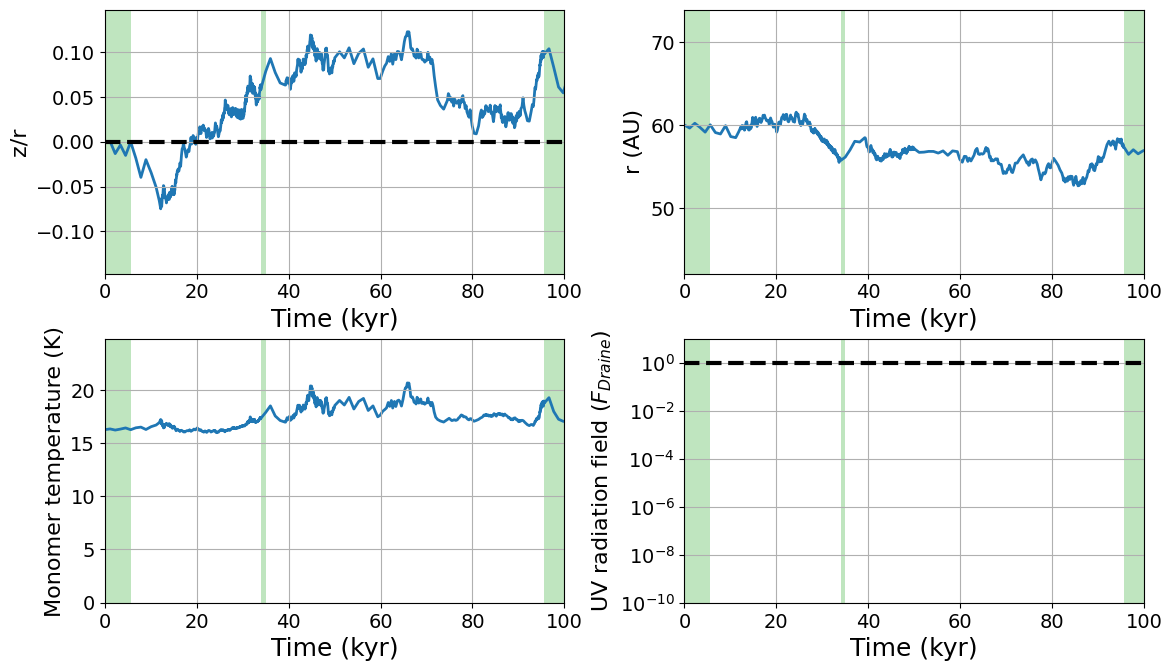

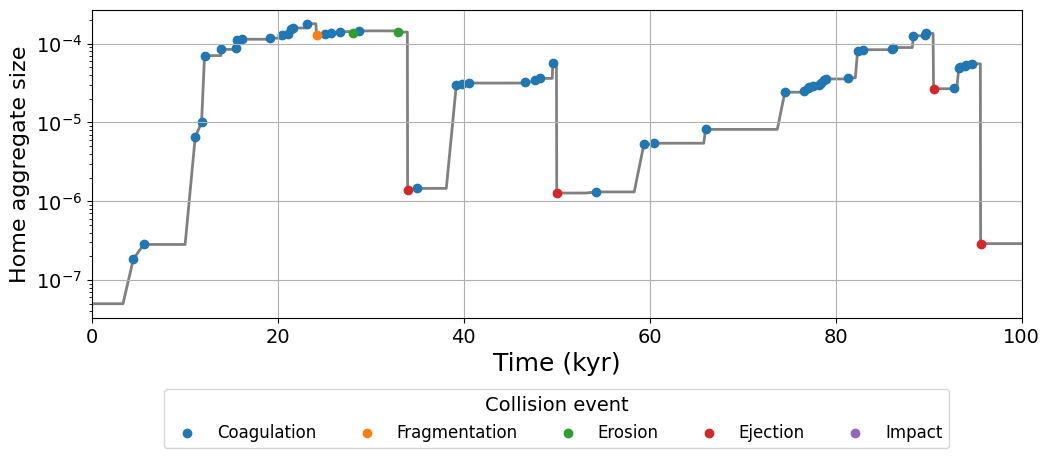

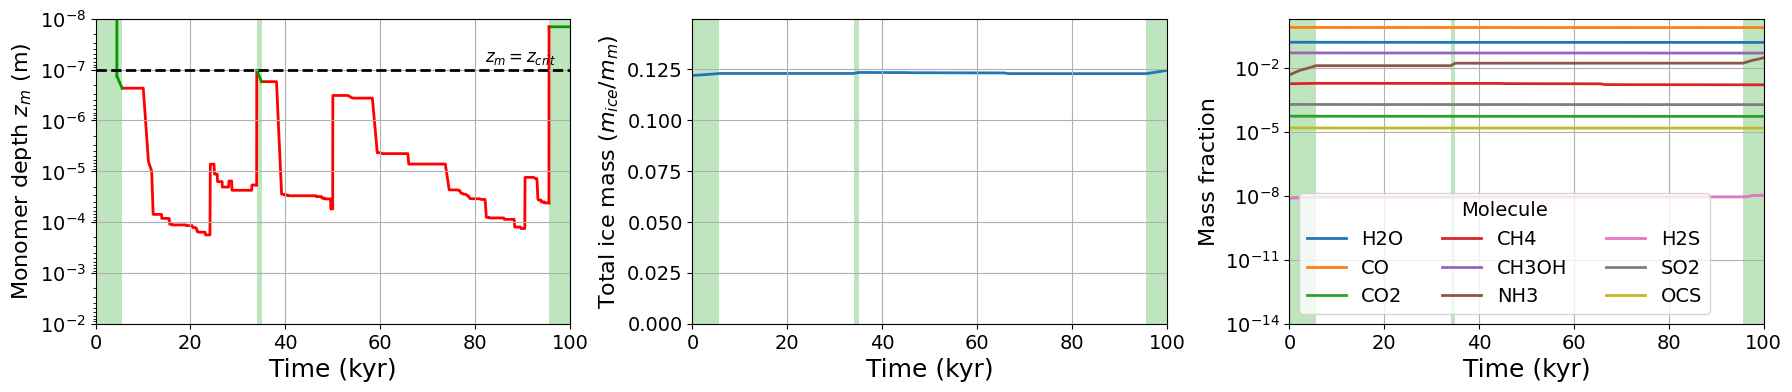

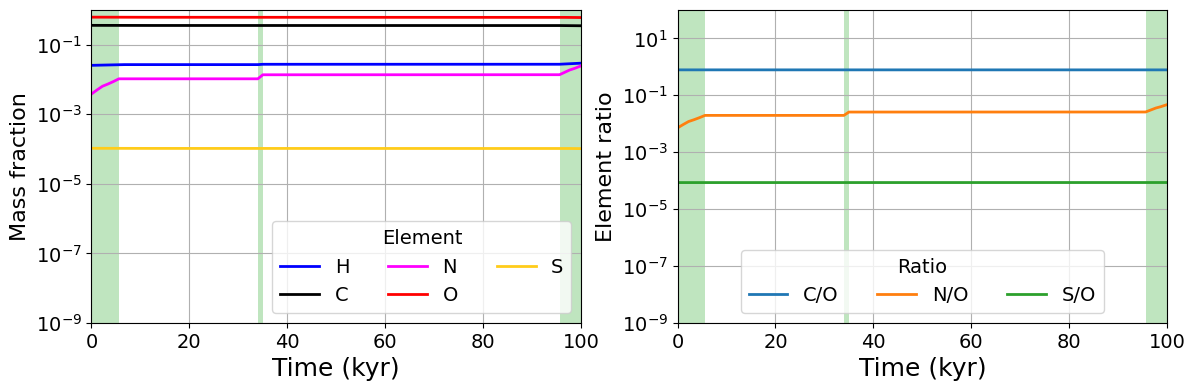

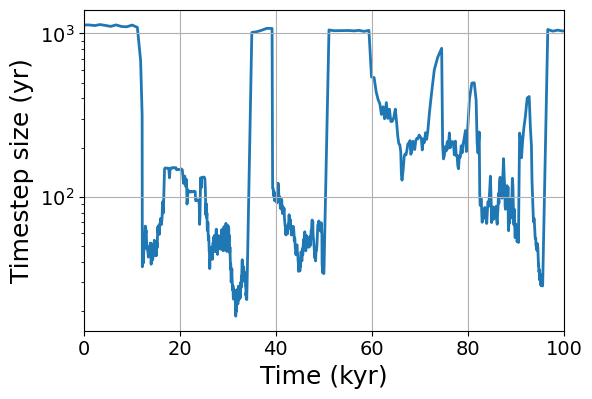

In [47]:
testModel(disk, pathdict, 0, 100, generate=True, name="DemoModel")